In [114]:
%load_ext autoreload
%autoreload 2
%matplotlib notebook

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [115]:
from torch import Tensor
import torch
import ipywidgets
import math
import matplotlib as mplot
import seaborn as sns
import time
import tqdm

In [116]:
num_params = 4
num_params

4

In [117]:
rng = torch.Generator()
rng.manual_seed(980856756)
func_params = torch.randn(num_params, generator=rng)
func_params

tensor([-1.0473, -0.9675, -0.3490, -0.1852])

In [118]:
def target_func(x,f_params=func_params):
    exp = torch.arange(start=f_params.size()[0]-1, end=-1, step=-1)
    return torch.sum(torch.pow(x.unsqueeze(1), exp)*f_params, dim=1)

<IPython.core.display.Javascript object>


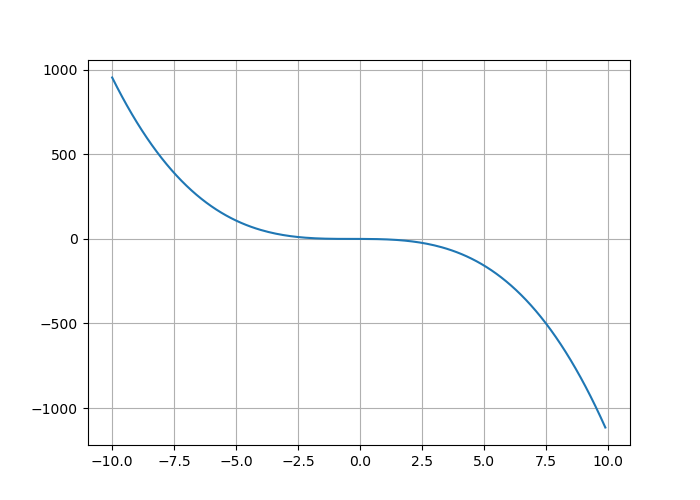

In [119]:
fig, axes = mplot.pyplot.subplots(figsize=(7, 5), nrows=1, ncols=1)

x = Tensor([i/10 for i in range(-100, 100, 1)])
y = target_func(x)
y_lims = [y.min().item(), y.max().item()]
axes.plot(x, y)
mplot.pyplot.grid(b=True)

mplot.pyplot.show()

#### 2 layers
- sigmoid with 1 neuron => relu => sigmod with 1 layer => output

In [120]:
def weighted_input(w, b, x):
    return w@x.transpose(0,1) + b

In [121]:
def estimate(w_l1, b_l1, w_l2, b_l2, x):
    
    #layer 1
    z = weighted_input(w_l1, b_l1, x)        
    y_l1 = torch.sigmoid(z)    
    y_l1 = y_l1.transpose(0,1)    
    # relu
    y_l1 = torch.where(y_l1>=0.5, y_l1, Tensor([0.5]))
    
    
    #layer 2
    z = weighted_input(w_l2, b_l2, y_l1)        
    y = torch.sigmoid(z)    
    y = y.transpose(0,1)        

    return y.sum(dim=1)

In [141]:
rng = torch.Generator()
rng.manual_seed(9898797)

num_neurons_l1 = 4
input_dim = 1

weights_l1 = -1*torch.randn(num_neurons_l1, input_dim, generator=rng)
weights_l1.requires_grad_()

bias_l1 = torch.randn(num_neurons_l1, 1, generator=rng)
bias_l1.requires_grad_()

weights_l1, bias_l1

(tensor([[ 0.7334],
         [-2.0636],
         [-0.0428],
         [ 1.2665]], requires_grad=True),
 tensor([[ 0.5696],
         [ 1.4258],
         [-1.6044],
         [ 0.2405]], requires_grad=True))

In [142]:
rng = torch.Generator()
rng.manual_seed(6578977)

num_neurons_l2 = 1

weights_l2 = -1*torch.randn(num_neurons_l2, num_neurons_l1, generator=rng)
weights_l2.requires_grad_()

bias_l2 = torch.randn(num_neurons_l2,1, generator=rng)
bias_l2.requires_grad_()

weights_l2, bias_l2

(tensor([[ 0.0989,  0.2317,  1.1911, -1.5823]], requires_grad=True),
 tensor([[-1.1113]], requires_grad=True))

In [143]:
err_func = torch.nn.L1Loss()

In [144]:
valid_x = Tensor([i/10 for i in range(-25, 20, 1)])
valid_y = torch.sigmoid(target_func(valid_x))

<IPython.core.display.Javascript object>


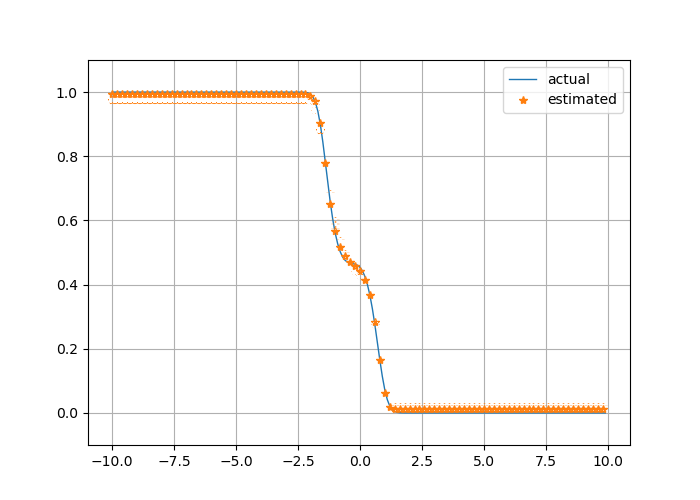

In [145]:
fig, axes = mplot.pyplot.subplots(figsize=(7, 5), nrows=1, ncols=1)

x = Tensor([i/10 for i in range(-100, 100, 1)])
y = torch.sigmoid(target_func(x))

e_y = estimate(weights_l1.data, bias_l1.data, weights_l2.data, bias_l2.data, x[::2].unsqueeze(1))

axes.set_ylim(-0.1, 1.1)

axes.plot(x, y, label='actual', linewidth=1)
plot1,  = axes.plot(x[::2], e_y, label='estimated', linestyle='', marker='*')
mplot.pyplot.grid(b=True)
mplot.pyplot.legend(['actual', 'estimated'])
mplot.pyplot.show()

In [147]:
N = 40_000
step_sz = N/1_000
next_update = step_sz
pbar = tqdm.notebook.tqdm(total=N, leave=False)

for i in range(0, N):
    
    if i < 2_000:
        learning_rate = 0.05
    elif i < 5_000:
        learning_rate = 0.05
    elif i < 8_000:
        learning_rate =0.05
    else:
        learning_rate = 0.05
    
    est_y = estimate(weights_l1, bias_l1, weights_l2, bias_l2, valid_x.unsqueeze(1))
    err = err_func(est_y, valid_y)
    err.backward()
    
    pbar.set_description(str(err.data.item()))
        
    weights_l1.data = weights_l1.data - learning_rate*weights_l1.grad.data    
    weights_l1.grad = None    
        
    bias_l1.data = bias_l1.data - learning_rate*bias_l1.grad.data
    bias_l1.grad = None    
    
    weights_l2.data = weights_l2.data - learning_rate*weights_l2.grad.data    
    weights_l2.grad = None    
        
    bias_l2.data = bias_l2.data - learning_rate*bias_l2.grad.data
    bias_l2.grad = None    
    
    pbar.update(1)
    
    if i >= next_update:
        e_y = estimate(weights_l1.data, bias_l1.data, weights_l2.data, bias_l2.data, x[::2].unsqueeze(1))
        plot1.set_ydata(e_y)    
        fig.canvas.draw()
        fig.canvas.flush_events()
        time.sleep(0.05)
        
        next_update += step_sz
    
pbar.close()    
print(err.item())

  0%|          | 0/40000 [00:00<?, ?it/s]

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

IOPub message rate exceed

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

IOPub message rate exceed